# Some potential audiences are:

1. Homeowners who want to increase the sale price of their homes through home improvement projects
2. Advocacy groups who want to promote affordable housing
3. Local elected officials who want to understand how their policy ideas (e.g. zoning changes, permitting) might impact home prices
4. Real estate investors looking for potential "fixer-uppers" or "tear-downs"

# Three things to be sure you establish during this phase are:

1. **Objectives:** what questions are you trying to answer, and for whom?
2. **Project plan:** you may want to establish more formal project management practices, such as daily stand-ups or using a Trello board, to plan the time you have remaining. Regardless, you should determine the division of labor, communication expectations, and timeline.
3. **Success criteria:** what does a successful project look like? How will you know when you have achieved it?

# READ THIS: Import the following data files from https://info.kingcounty.gov/assessor/DataDownload/default.aspx
## Download the files to local repo data directory
> 1) Real Property Sales (.ZIP, csv) <BR>
> 2) Parcel (.ZIP, csv) <BR>
> 3) Residential Building (.ZIP, csv) <BR>
> 4) Unit Breakdown (.ZIP)<BR>


In [87]:
import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from eda.eda import *
# from lr_model.build_lr import *

sns.set_style("whitegrid")
sns.set_context("poster")


### Andrew's scratchwork below:
____

In [4]:
df_merged = consolidate_data(year=2019, create=True)

Y:\Users\awyeh\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Sales file read.... (41818, 6)
Parcel file read.... (568310, 27)
ResBldg file read.... (517554, 30)
Merging data started....
Merging data ....done


In [5]:
cols = list(df_merged.columns)
cols = cols[2:4]  + cols[7:8] + cols[10:11] + cols[14:18] + cols[27:30] + cols[38:41] + cols[42:43] + cols[44:47] 
df = df_merged[cols] 

In [122]:
df = df_merged.copy()
df = df.dropna()
df = df[df['SalePrice'] != -300]
df = df[df['SalePrice'] != -100]
df.reset_index(drop = True, inplace = True)
# df.drop(columns = ['DocumentDate', 'DistrictName', 'Address', 'Merged_Key', 'PropertyType'], inplace = True)
print(df.shape)
df.head()


(24628, 60)


,Merged_Key,DocumentDate,SalePrice,PropertyType,PrincipalUse,PropertyClass,PropType,Area,SubArea,DistrictName,...,SqFtDeck,HeatSystem,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,YrRenovated,PcntComplete
0,2130430120,2019,560000,3,6,8,R,70.0,2.0,DUVALL,...,0,5,3,0,0,2,1,0,0,0
1,9406520630,2019,435000,11,6,8,R,56.0,3.0,MAPLE VALLEY,...,0,5,3,0,2,1,0,1,0,0
2,6154900010,2019,775000,11,6,8,R,39.0,3.0,SEATTLE,...,0,5,4,0,1,1,1,0,0,0
3,9376300695,2019,550000,3,6,8,R,82.0,11.0,SEATTLE,...,200,4,2,1,0,1,0,1,0,0
4,1245500098,2019,193000,3,6,8,R,74.0,8.0,KIRKLAND,...,220,5,3,0,1,1,0,1,0,0


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24628 entries, 0 to 24627
Data columns (total 60 columns):
Merged_Key                24628 non-null object
DocumentDate              24628 non-null object
SalePrice                 24628 non-null int64
PropertyType              24628 non-null int64
PrincipalUse              24628 non-null int64
PropertyClass             24628 non-null int64
PropType                  24628 non-null object
Area                      24628 non-null float64
SubArea                   24628 non-null float64
DistrictName              24628 non-null object
SqFtLot                   24628 non-null int64
WaterSystem               24628 non-null int64
SewerSystem               24628 non-null int64
Access                    24628 non-null int64
SeattleSkyline            24628 non-null int64
LakeWashington            24628 non-null int64
LakeSammamish             24628 non-null int64
SmallLakeRiverCreek       24628 non-null int64
OtherView                 24628 non-n

In [124]:
df.corr()

,SalePrice,PropertyType,PrincipalUse,PropertyClass,Area,SubArea,SqFtLot,WaterSystem,SewerSystem,Access,...,SqFtDeck,HeatSystem,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,YrRenovated,PcntComplete
SalePrice,1.000000,-0.053736,0.499435,-0.611682,-0.056068,0.044849,-0.026690,0.020149,0.046975,-0.009820,...,0.054200,0.032086,0.114737,0.083556,0.064536,0.147534,0.006996,0.061357,0.036490,-0.001069
PropertyType,-0.053736,1.000000,-0.045338,0.052511,-0.003116,0.014359,-0.073608,0.046246,0.030024,-0.002086,...,0.011405,0.038390,0.027025,0.020881,0.005216,0.025286,0.018070,0.000546,0.001673,0.019477
PrincipalUse,0.499435,-0.045338,1.000000,-0.676926,-0.027250,0.038581,-0.002513,0.008307,0.010856,0.011044,...,-0.023140,-0.020299,0.007342,-0.031734,-0.023291,0.015056,-0.039699,-0.028325,-0.011203,0.014499
PropertyClass,-0.611682,0.052511,-0.676926,1.000000,0.029453,-0.046394,0.004127,-0.007993,-0.015448,-0.011366,...,0.034207,0.035072,-0.016759,0.041860,0.037394,-0.022265,0.039993,0.035005,0.017780,-0.053791
Area,-0.056068,-0.003116,-0.027250,0.029453,1.000000,0.132373,0.085027,-0.179295,-0.236289,-0.057224,...,0.017001,-0.005864,0.023081,0.073635,-0.013716,0.060307,0.094277,-0.024727,-0.046519,-0.009049
SubArea,0.044849,0.014359,0.038581,-0.046394,0.132373,1.000000,-0.024208,0.047190,0.027503,0.043941,...,-0.005316,-0.005324,0.034133,0.036648,0.013517,0.015000,-0.007923,0.042266,-0.016369,-0.005821
SqFtLot,-0.026690,-0.073608,-0.002513,0.004127,0.085027,-0.024208,1.000000,-0.493844,-0.263670,0.004665,...,-0.026953,-0.231807,-0.177964,-0.041074,-0.040597,-0.109355,0.003597,-0.031796,-0.011023,-0.003236
WaterSystem,0.020149,0.046246,0.008307,-0.007993,-0.179295,0.047190,-0.493844,1.000000,0.481432,0.209003,...,-0.068743,0.124154,0.120055,0.026607,0.013985,0.058445,0.020978,0.030845,-0.011870,0.003744
SewerSystem,0.046975,0.030024,0.010856,-0.015448,-0.236289,0.027503,-0.263670,0.481432,1.000000,0.191080,...,-0.117052,0.088599,0.082478,0.019518,0.008890,0.056484,-0.010078,-0.004393,-0.007470,0.014979
Access,-0.009820,-0.002086,0.011044,-0.011366,-0.057224,0.043941,0.004665,0.209003,0.191080,1.000000,...,-0.108462,-0.037813,0.007923,-0.036959,-0.060725,-0.025411,-0.004952,-0.023577,-0.000901,0.008498


In [125]:
col = []
dic = df_merged.corr()['SalePrice'].to_dict()
for x in dic:
    if dic[x] >= abs(0.10):
        col.append(x)
        print(x)

SalePrice
PrincipalUse
LakeWashington
TidelandShoreland
NbrLivingUnits
Stories
SqFt1stFloor
SqFt2ndFloor
SqFtTotLiving
SqFtGarageAttached
SqFtOpenPorch
Bedrooms
BathFullCount


In [126]:
# # create a smaller df to save space and processing power
fsm_df = df_merged[col].copy()
fsm_df.dropna(inplace=True)
fsm = ols(formula="SalePrice ~ NbrLivingUnits + Stories + SqFt1stFloor + SqFt2ndFloor + SqFtTotLiving + SqFtGarageAttached + SqFtOpenPorch + Bedrooms + BathFullCount", data=fsm_df)
fsm_results = fsm.fit()
fsm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     375.7
Date:                Thu, 01 Oct 2020   Prob (F-statistic):               0.00
Time:                        12:02:49   Log-Likelihood:            -4.6702e+05
No. Observations:               30199   AIC:                         9.341e+05
Df Residuals:                   30189   BIC:                         9.341e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.309e+06   6.18e+04    -21.175      0.000   -1.43e+06   -1.19e+06
NbrLivingUnits      1.446e+06   4.31e+04     33.525      0.000    1.36e+06    1.53e+06
Stories             1.745e+05   2.29e+04      7.606      0.000     1.3e+05    2.19e+05
SqFt1stFloor          64.3776     26.880      2.395      0.017      11.692     117.063
SqFt2ndFloor        -101.9707     23.247     -4.386      0.000    -147.536     -56.405
SqFtTotLiving        380.9222     18.034     21.122      0.000     345.574     416.270
SqFtGarageAttached    12.1660     32.655      0.373      0.709     -51.839      76.171
SqFtOpenPorch        307.7534     63.810      4.823      0.000     182.683     432.824
Bedrooms           -1.217e+05   9962.601    -12.217      0.000   -1.41e+05   -1.02e+05
BathFullCount      -1.643e+04   1.31e+04     -1.253      0.210   -4.21e+04    9267.502
==============================================================================
Omnibus:                    57055.139   Durbin-Watson:                   0.753
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        152232768.592
Skew:                          14.418   Prob(JB):                         0.00
Kurtosis:                     349.630   Cond. No.                     2.75e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.75e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [127]:
# # create a smaller df to save space and processing power
fsm_df = df_merged[['SalePrice', 'SqFt1stFloor', 'SqFt2ndFloor', 'SqFtTotLiving', 'SqFtGarageAttached','SqFtGarageAttached','SqFtOpenPorch','SqFtEnclosedPorch','Bedrooms','BathHalfCount','BathFullCount']].copy()
fsm_df.dropna(inplace=True)
fsm = ols(formula="SalePrice ~ SqFt1stFloor + SqFt2ndFloor + SqFtTotLiving + SqFtGarageAttached + SqFtGarageAttached + SqFtOpenPorch + SqFtEnclosedPorch + Bedrooms + BathHalfCount + BathFullCount", data=fsm_df)
fsm_results = fsm.fit()
fsm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     236.9
Date:                Thu, 01 Oct 2020   Prob (F-statistic):               0.00
Time:                        12:02:49   Log-Likelihood:            -4.6759e+05
No. Observations:               30199   AIC:                         9.352e+05
Df Residuals:                   30189   BIC:                         9.353e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              3.001e+05   3.05e+04      9.826      0.000     2.4e+05     3.6e+05
SqFt1stFloor              6.5141     25.506      0.255      0.798     -43.480      56.508
SqFt2ndFloor            -19.5031     20.158     -0.968      0.333     -59.013      20.007
SqFtTotLiving           371.5526     18.300     20.303      0.000     335.684     407.421
SqFtGarageAttached[0]   -30.1488     16.653     -1.810      0.070     -62.789       2.492
SqFtGarageAttached[1]   -30.1488     16.653     -1.810      0.070     -62.789       2.492
SqFtOpenPorch           287.7428     65.025      4.425      0.000     160.291     415.194
SqFtEnclosedPorch       884.2497    204.802      4.318      0.000     482.830    1285.669
Bedrooms              -8.779e+04   1.01e+04     -8.713      0.000   -1.08e+05    -6.8e+04
BathHalfCount          8502.7352   1.55e+04      0.549      0.583   -2.19e+04    3.89e+04
BathFullCount          3.148e+04   1.33e+04      2.365      0.018    5390.588    5.76e+04
==============================================================================
Omnibus:                    58498.659   Durbin-Watson:                   0.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        155297047.098
Skew:                          15.297   Prob(JB):                         0.00
Kurtosis:                     352.976   Cond. No.                     9.75e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.59e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [128]:
df

,Merged_Key,DocumentDate,SalePrice,PropertyType,PrincipalUse,PropertyClass,PropType,Area,SubArea,DistrictName,...,SqFtDeck,HeatSystem,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,YrRenovated,PcntComplete
0,2130430120,2019,560000,3,6,8,R,70.0,2.0,DUVALL,...,0,5,3,0,0,2,1,0,0,0
1,9406520630,2019,435000,11,6,8,R,56.0,3.0,MAPLE VALLEY,...,0,5,3,0,2,1,0,1,0,0
2,6154900010,2019,775000,11,6,8,R,39.0,3.0,SEATTLE,...,0,5,4,0,1,1,1,0,0,0
3,9376300695,2019,550000,3,6,8,R,82.0,11.0,SEATTLE,...,200,4,2,1,0,1,0,1,0,0
4,1245500098,2019,193000,3,6,8,R,74.0,8.0,KIRKLAND,...,220,5,3,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24623,6113400046,2019,850000,11,6,8,R,49.0,8.0,NORMANDY PARK,...,240,5,5,1,0,2,1,0,0,0
24624,4254000130,2019,650000,11,6,8,R,70.0,2.0,DUVALL,...,0,5,4,1,0,2,0,1,0,0
24625,3985300006,2019,540000,3,6,8,R,2.0,2.0,SHORELINE,...,0,5,3,0,1,1,1,0,0,0
24626,5727500100,2019,3900,1,6,7,R,3.0,5.0,SHORELINE,...,0,1,3,0,0,1,1,0,0,0


In [129]:
df.select_dtypes(include = 'object').head()

,Merged_Key,DocumentDate,PropType,DistrictName,WfntAccessRights,WfntProximityInfluence,PowerLines,OtherNuisances,Address,BuildingNumber,ZipCode,DaylightBasement
0,2130430120,2019,R,DUVALL,N,N,N,N,27033 NE DOROTHY ST 98019,27033,98019,
1,9406520630,2019,R,MAPLE VALLEY,N,N,N,N,22848 SE 264TH CT 98038,22848,98038,
2,6154900010,2019,R,SEATTLE,N,N,N,N,10322 12TH AVE NW 98177,10322,98177,N
3,9376300695,2019,R,SEATTLE,N,N,N,N,8013 11TH AVE NW 98117,8013,98117,N
4,1245500098,2019,R,KIRKLAND,N,N,N,N,9823 FORBES CREEK DR 98033,9823,98033,


In [130]:
def dummying(df, col_name, keep = True):
    if col_name in df.columns:
        label_encoder = LabelEncoder()
        status_labels = label_encoder.fit_transform(df[f"{col_name}"])
        label_encoder.classes_
        df[f"{col_name}_Encoded"] = status_labels
    if keep == False: df.drop(columns = [col_name], inplace = True, errors = 'ignore')
    return df

In [131]:
label_encoder = LabelEncoder()
status_labels = label_encoder.fit_transform(df["WfntAccessRights"])
label_encoder.classes_
df["WfntAccessRights_Encoded"] = status_labels
df.drop(columns = ["WfntAccessRights"], inplace = True, errors = 'ignore')

In [132]:
df["WfntAccessRights_Encoded"]

0        0
1        0
2        0
3        0
4        0
        ..
24623    1
24624    0
24625    0
24626    0
24627    0
Name: WfntAccessRights_Encoded, Length: 24628, dtype: int32

In [133]:
label_encoder = LabelEncoder()
status_labels = label_encoder.fit_transform(df["WfntProximityInfluence"])
label_encoder.classes_
df["WfntProximityInfluence_Encoded"] = status_labels

In [134]:
label_encoder = LabelEncoder()
status_labels = label_encoder.fit_transform(df["PowerLines"])
label_encoder.classes_
df["PowerLines"] = status_labels

In [135]:
label_encoder = LabelEncoder()
status_labels = label_encoder.fit_transform(df["OtherNuisances"])
label_encoder.classes_
df["OtherNuisances_Encoded"] = status_labels

In [136]:
label_encoder = LabelEncoder()
status_labels = label_encoder.fit_transform(df["BuildingNumber"])
label_encoder.classes_
df["BuildingNumber_Encoded"] = status_labels

In [137]:
label_encoder = LabelEncoder()
status_labels = label_encoder.fit_transform(df["ZipCode"])
label_encoder.classes_
df["ZipCode_Encoded"] = status_labels

In [138]:
label_encoder = LabelEncoder()
status_labels = label_encoder.fit_transform(df["DaylightBasement"])
label_encoder.classes_
df["DaylightBasement_Encoded"] = status_labels

In [139]:
df.corr()

,SalePrice,PropertyType,PrincipalUse,PropertyClass,Area,SubArea,SqFtLot,WaterSystem,SewerSystem,Access,...,FpSingleStory,FpMultiStory,YrRenovated,PcntComplete,WfntAccessRights_Encoded,WfntProximityInfluence_Encoded,OtherNuisances_Encoded,BuildingNumber_Encoded,ZipCode_Encoded,DaylightBasement_Encoded
SalePrice,1.000000,-0.053736,0.499435,-0.611682,-0.056068,0.044849,-0.026690,0.020149,0.046975,-0.009820,...,0.006996,0.061357,0.036490,-0.001069,0.006001,-0.001686,-0.006010,0.031623,-0.087994,0.011395
PropertyType,-0.053736,1.000000,-0.045338,0.052511,-0.003116,0.014359,-0.073608,0.046246,0.030024,-0.002086,...,0.018070,0.000546,0.001673,0.019477,-0.005709,0.000669,-0.005986,0.005719,-0.009020,0.004094
PrincipalUse,0.499435,-0.045338,1.000000,-0.676926,-0.027250,0.038581,-0.002513,0.008307,0.010856,0.011044,...,-0.039699,-0.028325,-0.011203,0.014499,-0.005140,-0.001986,0.010231,-0.002807,-0.049614,-0.004271
PropertyClass,-0.611682,0.052511,-0.676926,1.000000,0.029453,-0.046394,0.004127,-0.007993,-0.015448,-0.011366,...,0.039993,0.035005,0.017780,-0.053791,0.007516,0.003623,-0.018309,-0.005074,0.067392,0.013230
Area,-0.056068,-0.003116,-0.027250,0.029453,1.000000,0.132373,0.085027,-0.179295,-0.236289,-0.057224,...,0.094277,-0.024727,-0.046519,-0.009049,0.024858,0.012642,-0.030361,-0.033409,-0.334211,-0.081215
SubArea,0.044849,0.014359,0.038581,-0.046394,0.132373,1.000000,-0.024208,0.047190,0.027503,0.043941,...,-0.007923,0.042266,-0.016369,-0.005821,-0.017046,-0.007423,-0.012529,0.106594,-0.304029,0.036994
SqFtLot,-0.026690,-0.073608,-0.002513,0.004127,0.085027,-0.024208,1.000000,-0.493844,-0.263670,0.004665,...,0.003597,-0.031796,-0.011023,-0.003236,-0.006238,-0.002008,-0.009295,-0.020126,-0.030438,-0.065159
WaterSystem,0.020149,0.046246,0.008307,-0.007993,-0.179295,0.047190,-0.493844,1.000000,0.481432,0.209003,...,0.020978,0.030845,-0.011870,0.003744,0.003497,-0.017332,-0.000823,0.017633,0.092835,0.080878
SewerSystem,0.046975,0.030024,0.010856,-0.015448,-0.236289,0.027503,-0.263670,0.481432,1.000000,0.191080,...,-0.010078,-0.004393,-0.007470,0.014979,-0.026383,-0.013671,-0.005319,0.074812,0.147298,0.069330
Access,-0.009820,-0.002086,0.011044,-0.011366,-0.057224,0.043941,0.004665,0.209003,0.191080,1.000000,...,-0.004952,-0.023577,-0.000901,0.008498,-0.061212,-0.014408,-0.015087,0.006953,0.035689,-0.015079


In [140]:
df.select_dtypes(include = 'object').columns

Index(['Merged_Key', 'DocumentDate', 'PropType', 'DistrictName',
       'WfntProximityInfluence', 'OtherNuisances', 'Address', 'BuildingNumber',
       'ZipCode', 'DaylightBasement'],
      dtype='object')

In [141]:
def dummying(df, col_name, keep = True):
    if col_name in df.columns:
        label_encoder = LabelEncoder()
        status_labels = label_encoder.fit_transform(df[f"{col_name}"])
        label_encoder.classes_
        df[f"{col_name}_Encoded"] = status_labels
    if keep == False: df.drop(columns = [col_name], inplace = True, errors = 'ignore')
    return df

In [142]:
def dummying_df(df, keep = True):
    cols = df.select_dtypes(include = 'object').columns
    label_encoder = LabelEncoder()
    for col in cols:
        status_labels = label_encoder.fit_transform(df[f"{col}"])
        df[f"{col}_Encoded"] = status_labels
        if keep == False: df.drop(columns = [col], inplace = True, errors = 'ignore')
    return df

In [143]:
df.select_dtypes(include = 'object').columns

Index(['Merged_Key', 'DocumentDate', 'PropType', 'DistrictName',
       'WfntProximityInfluence', 'OtherNuisances', 'Address', 'BuildingNumber',
       'ZipCode', 'DaylightBasement'],
      dtype='object')

In [144]:
df = dummying_df(df, False)

In [145]:
df.select_dtypes(include = 'object').columns

Index([], dtype='object')

In [146]:
df

,SalePrice,PropertyType,PrincipalUse,PropertyClass,Area,SubArea,SqFtLot,WaterSystem,SewerSystem,Access,...,WfntProximityInfluence_Encoded,OtherNuisances_Encoded,BuildingNumber_Encoded,ZipCode_Encoded,DaylightBasement_Encoded,Merged_Key_Encoded,DocumentDate_Encoded,PropType_Encoded,DistrictName_Encoded,Address_Encoded
0,560000,3,6,8,70.0,2.0,10523,2,2,4,...,0,0,6579,19,0,6119,0,0,11,12579
1,435000,11,6,8,56.0,3.0,7392,2,2,4,...,0,0,5278,35,0,22751,0,0,21,10273
2,775000,11,6,8,39.0,3.0,7102,2,2,4,...,0,0,185,94,1,15761,0,0,32,473
3,550000,3,6,8,82.0,11.0,2500,2,2,4,...,0,0,11105,78,1,22720,0,0,32,21566
4,193000,3,6,8,74.0,8.0,9670,2,2,4,...,0,0,12029,32,0,3146,0,0,19,23522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24623,850000,11,6,8,49.0,8.0,15770,2,2,3,...,0,0,4260,92,1,15577,0,0,26,8423
24624,650000,11,6,8,70.0,2.0,15634,2,2,4,...,0,0,2538,19,0,13180,0,0,11,5261
24625,540000,3,6,8,2.0,2.0,9568,2,2,4,...,0,1,4575,91,1,12224,0,0,33,8988
24626,3900,1,6,7,3.0,5.0,7221,2,2,4,...,0,0,3175,91,0,15322,0,0,33,6490


In [147]:
df.columns

Index(['SalePrice', 'PropertyType', 'PrincipalUse', 'PropertyClass', 'Area',
       'SubArea', 'SqFtLot', 'WaterSystem', 'SewerSystem', 'Access',
       'SeattleSkyline', 'LakeWashington', 'LakeSammamish',
       'SmallLakeRiverCreek', 'OtherView', 'WfntLocation', 'WfntFootage',
       'WfntBank', 'WfntPoorQuality', 'WfntRestrictedAccess',
       'TidelandShoreland', 'TrafficNoise', 'AirportNoise', 'PowerLines',
       'BldgNbr', 'NbrLivingUnits', 'Stories', 'SqFt1stFloor', 'SqFtHalfFloor',
       'SqFt2ndFloor', 'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf',
       'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement',
       'SqFtGarageAttached', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck',
       'HeatSystem', 'Bedrooms', 'BathHalfCount', 'Bath3qtrCount',
       'BathFullCount', 'FpSingleStory', 'FpMultiStory', 'YrRenovated',
       'PcntComplete', 'WfntAccessRights_Encoded',
       'WfntProximityInfluence_Encoded', 'OtherNuisances_Encoded',
       'BuildingNumber_Encoded'

# 2. Having a porch increases home sale price

In [148]:
df_porch = df[['SalePrice','SqFtOpenPorch', 'SqFtEnclosedPorch']].copy()
df_porch.head()

,SalePrice,SqFtOpenPorch,SqFtEnclosedPorch
0,560000,180,0
1,435000,45,0
2,775000,0,0
3,550000,0,0
4,193000,0,0


In [149]:
df_porch['SqFtEnclosedPorch'].describe()

count    24628.000000
mean         6.160590
std         38.838703
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1840.000000
Name: SqFtEnclosedPorch, dtype: float64

In [150]:
df_porch['SqFtOpenPorch'].describe()

count    24628.000000
mean        66.914731
std        119.585018
min          0.000000
25%          0.000000
50%          0.000000
75%         90.000000
max       2870.000000
Name: SqFtOpenPorch, dtype: float64

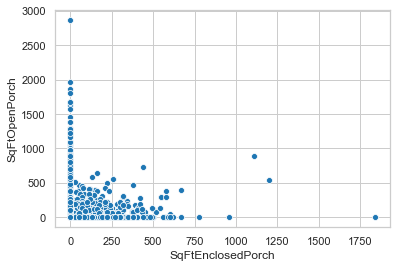

In [151]:
sns.scatterplot(data=df_porch, x="SqFtEnclosedPorch", y="SqFtOpenPorch")

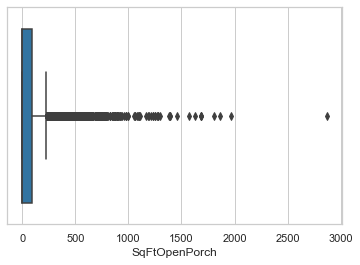

In [152]:
sns.boxplot(df_porch['SqFtOpenPorch'])

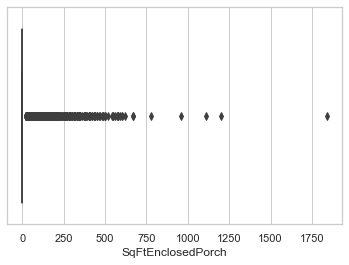

In [153]:
sns.boxplot(df_porch['SqFtEnclosedPorch'])

In [154]:
# # create a smaller df to save space and processing power
fsm_df = df_porch[['SalePrice', 'SqFtEnclosedPorch', 'SqFtOpenPorch']].copy()
fsm_df.dropna(inplace=True)
fsm = ols(formula="SalePrice ~ SqFtEnclosedPorch + SqFtOpenPorch", data=fsm_df)
fsm_results = fsm.fit()
fsm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     206.8
Date:                Thu, 01 Oct 2020   Prob (F-statistic):           8.58e-90
Time:                        12:03:02   Log-Likelihood:            -3.8313e+05
No. Observations:               24628   AIC:                         7.663e+05
Df Residuals:                   24625   BIC:                         7.663e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          7.417e+05   1.02e+04     72.917      0.000    7.22e+05    7.62e+05
SqFtEnclosedPorch   919.4252    226.461      4.060      0.000     475.548    1363.302
SqFtOpenPorch      1464.6329     73.550     19.914      0.000    1320.471    1608.795
==============================================================================
Omnibus:                    46621.547   Durbin-Watson:                   0.727
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        106083094.602
Skew:                          14.561   Prob(JB):                         0.00
Kurtosis:                     323.203   Cond. No.                         159.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

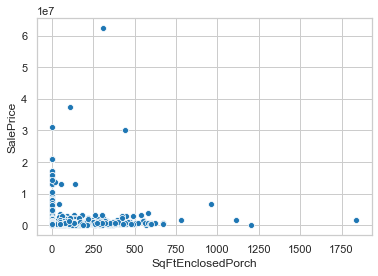

In [155]:
sns.scatterplot(data=df_porch, x="SqFtEnclosedPorch", y="SalePrice")

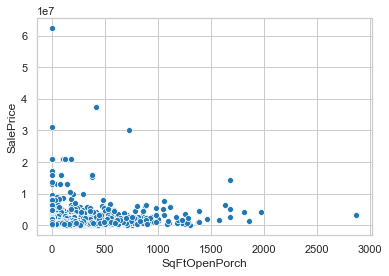

In [156]:
sns.scatterplot(data=df_porch, x="SqFtOpenPorch", y="SalePrice")

In [157]:
df_porch.sort_values(by=['SqFtOpenPorch'], ascending = False).head()

,SalePrice,SqFtOpenPorch,SqFtEnclosedPorch
14090,3250000,2870,0
8673,4373150,1970,0
1861,1225000,1860,0
19550,4200000,1810,0
21017,5300000,1680,0


In [158]:
df_porch.sort_values(by=['SqFtEnclosedPorch'], ascending = False).head()

,SalePrice,SqFtOpenPorch,SqFtEnclosedPorch
15993,1600000,0,1840
7687,27225,540,1200
23593,1685000,890,1110
9087,6670000,0,960
13512,1700000,0,780


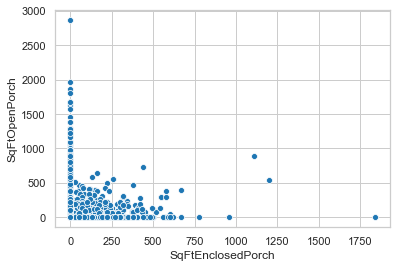

In [159]:
sns.scatterplot(data=df_porch, x="SqFtEnclosedPorch", y="SqFtOpenPorch")

In [160]:
df_porch['SalePrice'].describe()

count    2.462800e+04
mean     8.454052e+05
std      1.391746e+06
min      1.000000e+01
25%      4.479000e+05
50%      6.400000e+05
75%      8.850000e+05
max      6.250000e+07
Name: SalePrice, dtype: float64

In [161]:
df_porch['SalePrice'].min()

10

In [162]:
df_porch = df_porch[df_porch['SalePrice'] != -300]
df_porch = df_porch[df_porch['SalePrice'] != -100]

In [163]:
df_porch['SalePrice'].describe()

count    2.462800e+04
mean     8.454052e+05
std      1.391746e+06
min      1.000000e+01
25%      4.479000e+05
50%      6.400000e+05
75%      8.850000e+05
max      6.250000e+07
Name: SalePrice, dtype: float64

In [164]:
def sale_tier(s):
    d = df_porch['SalePrice'].describe()
    r = ''
    if s >= d['75%']:
        r = '+75%'
    elif s >= d['50%']:
        r = '+50%'
    elif s >= d['25%']:
        r = '+25%'
    else:
        r = '+0%'
    return r

In [165]:
df_porch['SaleTier'] = df_porch['SalePrice'].apply(lambda x: sale_tier(x))

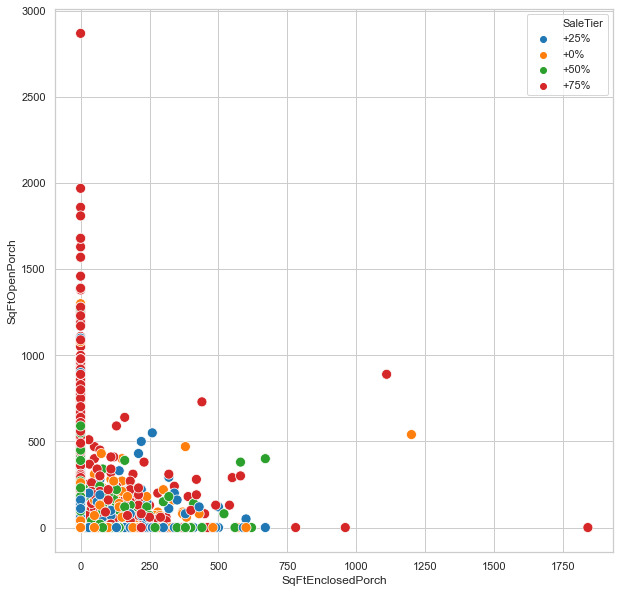

In [166]:
sns.set_context("notebook")
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.scatterplot(data=df_porch, x="SqFtEnclosedPorch", y="SqFtOpenPorch", hue = 'SaleTier', s=100)

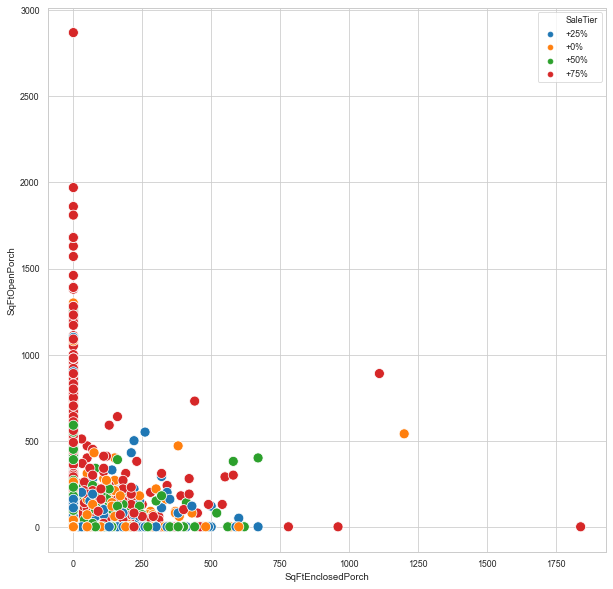

In [167]:
sns.set_context("paper")
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.scatterplot(data=df_porch, x="SqFtEnclosedPorch", y="SqFtOpenPorch", hue = 'SaleTier', s=100)

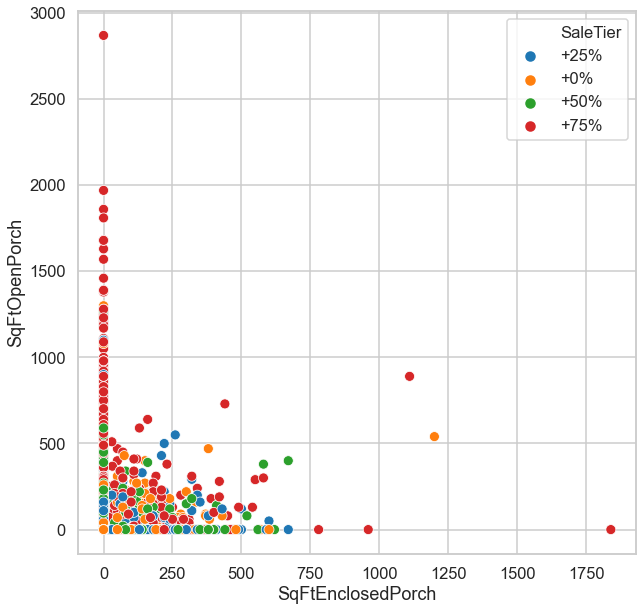

In [168]:
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.scatterplot(data=df_porch, x="SqFtEnclosedPorch", y="SqFtOpenPorch", hue = 'SaleTier', s=100)

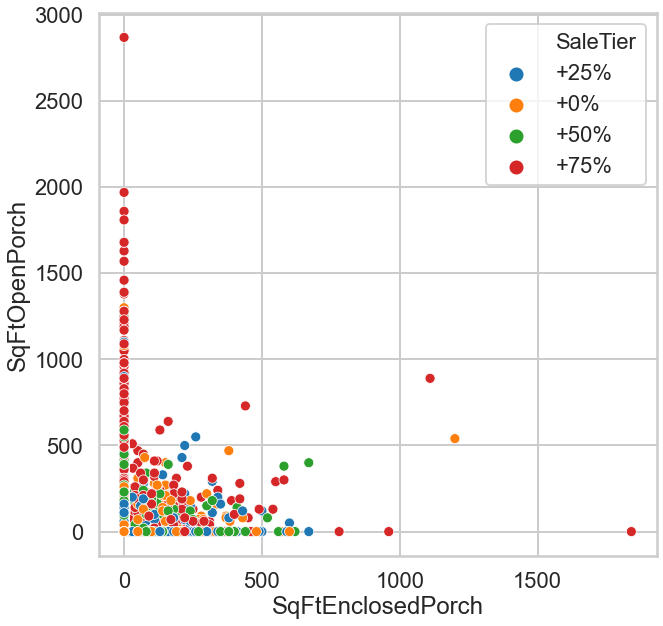

In [487]:
sns.set_context("poster")
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.scatterplot(data=df_porch, x="SqFtEnclosedPorch", y="SqFtOpenPorch", hue = 'SaleTier', s=100)

In [170]:
df_porch['TotalPorch'] = df_porch['SqFtOpenPorch'] + df_porch['SqFtEnclosedPorch']
df_porch.head()

,SalePrice,SqFtOpenPorch,SqFtEnclosedPorch,SaleTier,TotalPorch
0,560000,180,0,+25%,180
1,435000,45,0,+0%,45
2,775000,0,0,+50%,0
3,550000,0,0,+25%,0
4,193000,0,0,+0%,0


In [171]:
# # create a smaller df to save space and processing power
fsm_df = df_porch[['SalePrice', 'TotalPorch']].copy()
fsm_df.dropna(inplace=True)
fsm = ols(formula="SalePrice ~ TotalPorch", data=fsm_df)
fsm_results = fsm.fit()
fsm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     408.3
Date:                Thu, 01 Oct 2020   Prob (F-statistic):           4.62e-90
Time:                        12:04:14   Log-Likelihood:            -3.8313e+05
No. Observations:               24628   AIC:                         7.663e+05
Df Residuals:                   24626   BIC:                         7.663e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.422e+05   1.02e+04     72.973      0.000    7.22e+05    7.62e+05
TotalPorch  1412.1591     69.887     20.206      0.000    1275.177    1549.141
==============================================================================
Omnibus:                    46564.586   Durbin-Watson:                   0.727
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        104833290.714
Skew:                          14.525   Prob(JB):                         0.00
Kurtosis:                     321.302   Cond. No.                         168.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

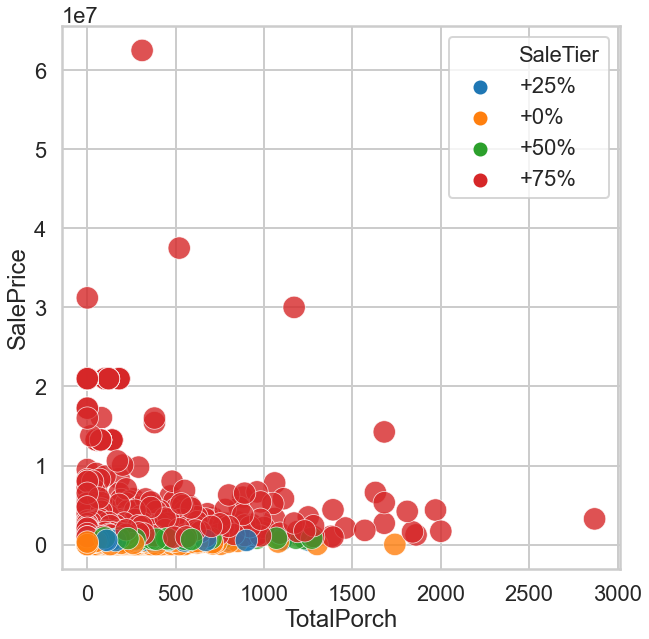

In [495]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.scatterplot(data=df_porch, x="TotalPorch", y="SalePrice", hue = 'SaleTier', alpha = 0.8, s=500)

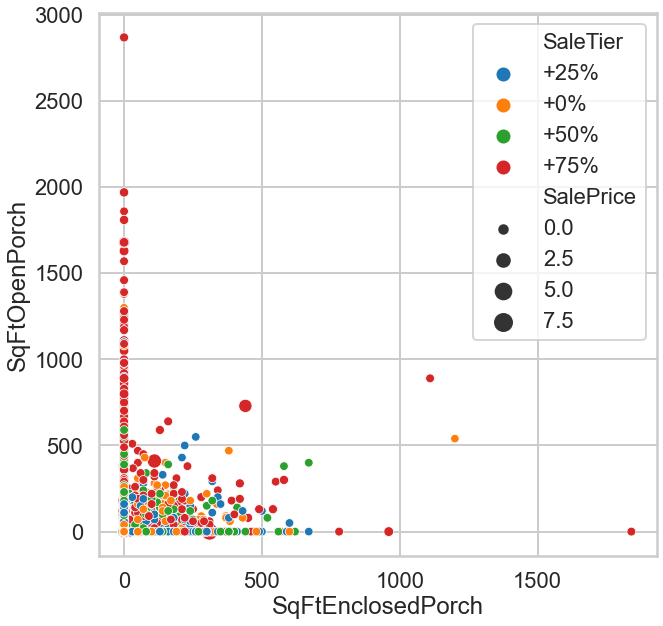

In [492]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.scatterplot(data=df_porch, x="SqFtEnclosedPorch", y="SqFtOpenPorch", size = 'SalePrice', hue = 'SaleTier', s=1000)

In [173]:
def porchyn(p):
    if p > 0:
        return 1
    else:
        return 0

In [174]:
df_porch['Porchyn'] = df_porch['TotalPorch'].apply(lambda x: porchyn(x))
df_porch.head()

,SalePrice,SqFtOpenPorch,SqFtEnclosedPorch,SaleTier,TotalPorch,Porchyn
0,560000,180,0,+25%,180,1
1,435000,45,0,+0%,45,1
2,775000,0,0,+50%,0,0
3,550000,0,0,+25%,0,0
4,193000,0,0,+0%,0,0


In [478]:
p_outlier = ( 3 * df_p.std() ) + df_p.mean()
np_outlier = ( 3 * df_np.std() ) + df_np.mean()
df1 = df_porch[(df_porch['Porchyn'] == 0) & (df_porch['SalePrice'] <= np_outlier)]
df2 = df_porch[(df_porch['Porchyn'] == 1) & (df_porch['SalePrice'] <= p_outlier)]
df_porch_cheap = df1.append(df2)
df_porch_cheap.shape

(24462, 6)

In [479]:
# # create a smaller df to save space and processing power
fsm_df = df_porch_cheap[['SalePrice', 'Porchyn']].copy()
fsm_df.dropna(inplace=True)
fsm = ols(formula="SalePrice ~ Porchyn", data=fsm_df)
fsm_results = fsm.fit()
fsm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     931.7
Date:                Thu, 01 Oct 2020   Prob (F-statistic):          7.53e-201
Time:                        16:08:41   Log-Likelihood:            -3.5569e+05
No. Observations:               24462   AIC:                         7.114e+05
Df Residuals:                   24460   BIC:                         7.114e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.528e+05   4552.384    143.391      0.000    6.44e+05    6.62e+05
Porchyn      1.95e+05   6389.641     30.523      0.000    1.83e+05    2.08e+05
==============================================================================
Omnibus:                    15070.539   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           198790.652
Skew:                           2.775   Prob(JB):                         0.00
Kurtosis:                      15.816   Cond. No.                         2.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

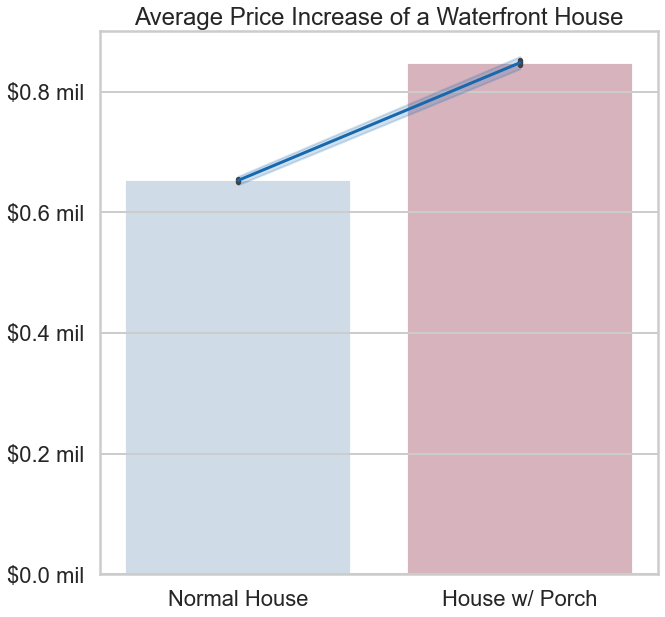

In [484]:
fig, ax = plt.subplots(figsize=(10, 10))
bar_colors = ['#c6d7eb', '#d9a5b3', '#1868ae']
x_ticks = ['Normal House', 'House w/ Porch']
y_ticks = ['$0.0 mil', '$0.2 mil', '$0.4 mil', '$0.6 mil', '$0.8 mil', '$1.0 mil']
ax = sns.barplot(data = df_porch_cheap, x = "Porchyn", y = "SalePrice", alpha = 0.9, palette = bar_colors, ci = 50, zorder = 0)
sns.lineplot(data = df_porch_cheap, x = 'Porchyn', y = 'SalePrice', alpha = 1, color = bar_colors[2], zorder = 10)
ax.set_title("Average Price Increase of a Waterfront House")
ax.set_xlabel('')
ax.set_xticklabels(x_ticks)
ax.set_ylabel('')
ax.set_yticklabels(y_ticks)
figure = ax.get_figure().savefig("poch_avg_price", dpi = 400, bbox_inches = "tight")

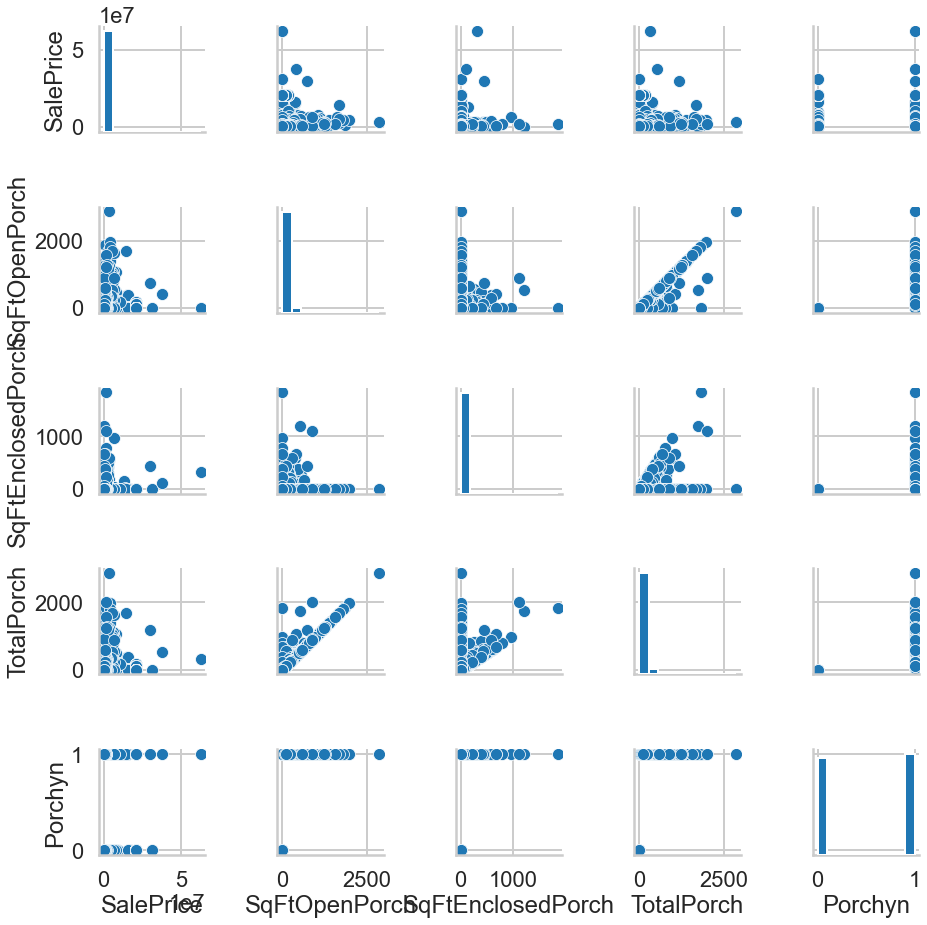

In [176]:
sns.pairplot(df_porch)

In [177]:
# # create a smaller df to save space and processing power
fsm_df = df_porch[['SalePrice', 'Porchyn']].copy()
fsm_df.dropna(inplace=True)
fsm = ols(formula="SalePrice ~ Porchyn", data=fsm_df)
fsm_results = fsm.fit()
fsm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     155.1
Date:                Thu, 01 Oct 2020   Prob (F-statistic):           1.68e-35
Time:                        12:04:27   Log-Likelihood:            -3.8326e+05
No. Observations:               24628   AIC:                         7.665e+05
Df Residuals:                   24626   BIC:                         7.665e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.335e+05   1.26e+04     58.175      0.000    7.09e+05    7.58e+05
Porchyn     2.203e+05   1.77e+04     12.455      0.000    1.86e+05    2.55e+05
==============================================================================
Omnibus:                    46458.430   Durbin-Watson:                   0.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        103739440.106
Skew:                          14.452   Prob(JB):                         0.00
Kurtosis:                     319.637   Cond. No.                         2.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [178]:
df_p = df_porch[df_porch['TotalPorch'] > 0]['SalePrice'].reset_index(drop = True)
df_np = df_porch[df_porch['TotalPorch'] == 0]['SalePrice'].reset_index(drop = True)

[(-0.5, 0.5), (0.0, 10000000.0)]

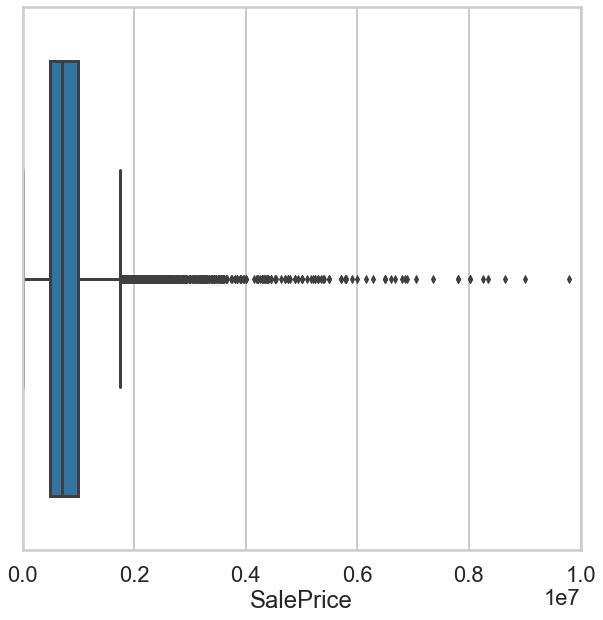

In [179]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.boxplot(df_p)
ax.set(xlim=(0, 10000000), ylim = (-0.5,0.5))

[(-0.5, 0.5), (0.0, 10000000.0)]

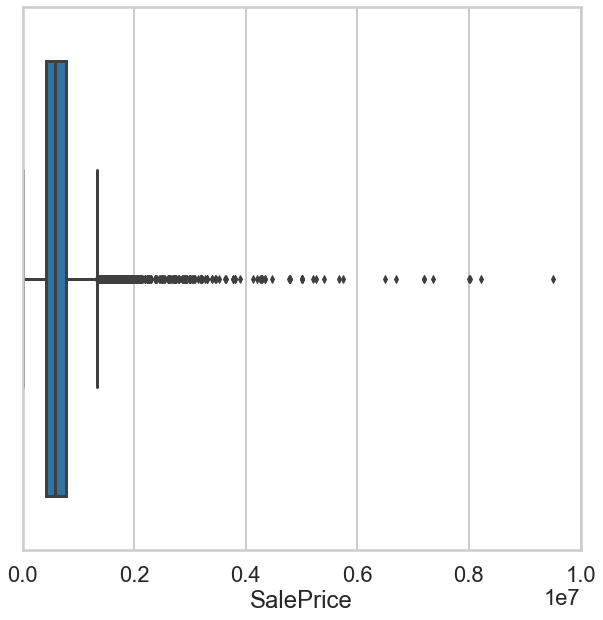

In [180]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.boxplot(df_np)
ax.set(xlim=(0, 10000000), ylim = (-0.5,0.5))

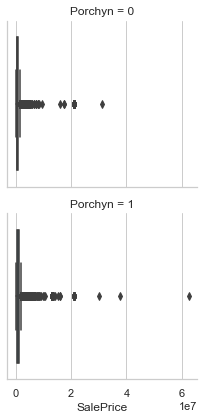

In [181]:
# fig, ax = plt.subplots(figsize=(10, 10))
# ax = sns.boxplot(df_p)
# ax.set(xlim=(0, 10000000), ylim = (-0.5,0.5))
sns.set_context('notebook')
g = sns.FacetGrid(df_porch, row = "Porchyn")
g.map(sns.boxplot, "SalePrice", order = [0,1])

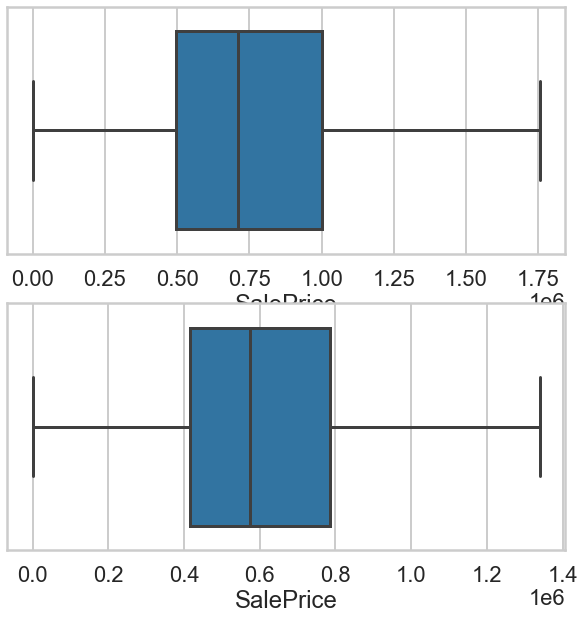

In [206]:
sns.set_context('poster')
fig, axs = plt.subplots(2, 1, figsize = (10,10))
sns.boxplot(y=df_p,  orient='h' , ax=axs[0], showfliers = False)
sns.boxplot(y=df_np,  orient='h' , ax=axs[1], showfliers = False)

In [184]:
from scipy.stats import ttest_ind
ttest_result = ttest_ind(df_p, df_np, equal_var = False)
ttest_result

Ttest_indResult(statistic=12.484108449410947, pvalue=1.1723568002750044e-35)

In [185]:
p = ttest_result.pvalue
p

1.1723568002750044e-35

# p value is small so we fail to reject the null hypothesis; we accept the alternative hypothesis

# 3) Having a beachfront or lakefront increases home sale price

In [186]:
df.columns

Index(['SalePrice', 'PropertyType', 'PrincipalUse', 'PropertyClass', 'Area',
       'SubArea', 'SqFtLot', 'WaterSystem', 'SewerSystem', 'Access',
       'SeattleSkyline', 'LakeWashington', 'LakeSammamish',
       'SmallLakeRiverCreek', 'OtherView', 'WfntLocation', 'WfntFootage',
       'WfntBank', 'WfntPoorQuality', 'WfntRestrictedAccess',
       'TidelandShoreland', 'TrafficNoise', 'AirportNoise', 'PowerLines',
       'BldgNbr', 'NbrLivingUnits', 'Stories', 'SqFt1stFloor', 'SqFtHalfFloor',
       'SqFt2ndFloor', 'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf',
       'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement',
       'SqFtGarageAttached', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck',
       'HeatSystem', 'Bedrooms', 'BathHalfCount', 'Bath3qtrCount',
       'BathFullCount', 'FpSingleStory', 'FpMultiStory', 'YrRenovated',
       'PcntComplete', 'WfntAccessRights_Encoded',
       'WfntProximityInfluence_Encoded', 'OtherNuisances_Encoded',
       'BuildingNumber_Encoded'

In [187]:
df['WfntLocation'].value_counts()

0    24071
9      152
8      128
6      128
3      101
7       37
5        7
1        4
Name: WfntLocation, dtype: int64

In [188]:
df_wf = df[['SalePrice', 'WfntLocation']].copy()

In [189]:
def wfyn(w):
    if w > 0:
        return 1
    else:
        return 0

In [190]:
df_wf['Wfntyn'] = df_wf['WfntLocation'].apply(lambda x: wfyn(x))
df_wf.head()

,SalePrice,WfntLocation,Wfntyn
0,560000,0,0
1,435000,0,0
2,775000,0,0
3,550000,0,0
4,193000,0,0


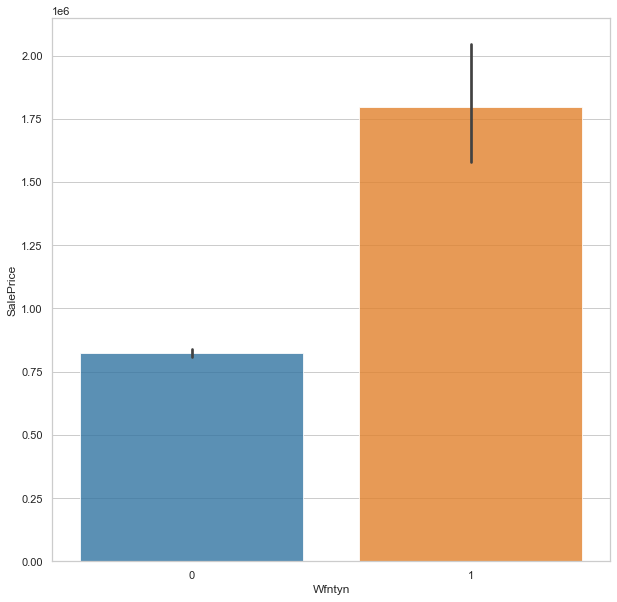

In [191]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(data=df_wf, x="Wfntyn", y="SalePrice", alpha = 0.8)

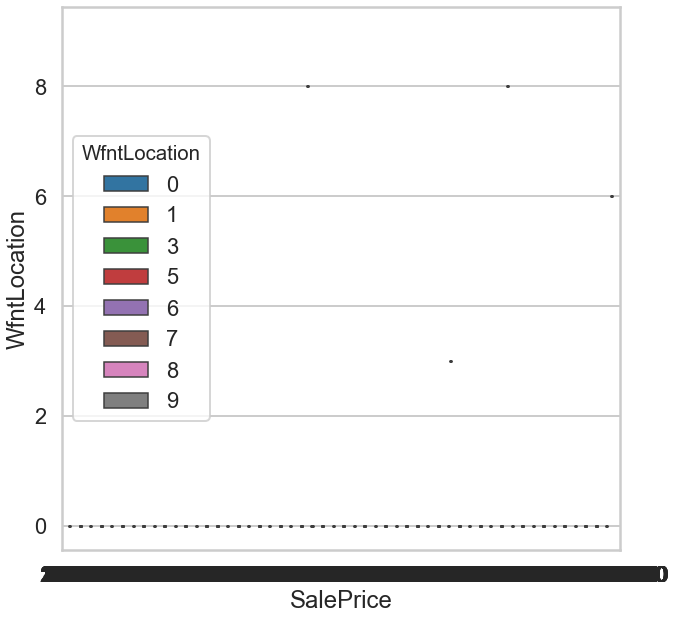

In [225]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.boxplot(data=df_wf, y="WfntLocation", x="SalePrice",hue = 'WfntLocation')

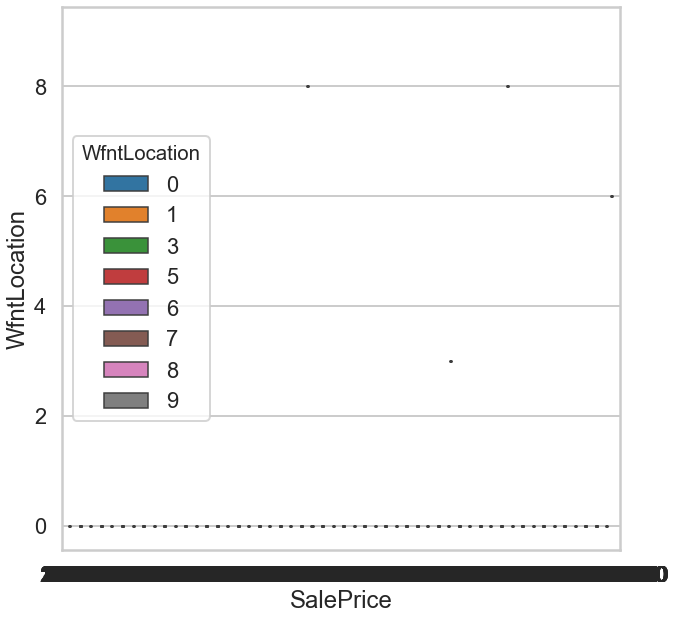

In [248]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.boxplot(data=df_wf, y="WfntLocation", x="SalePrice", orient = 'v', hue = 'WfntLocation')

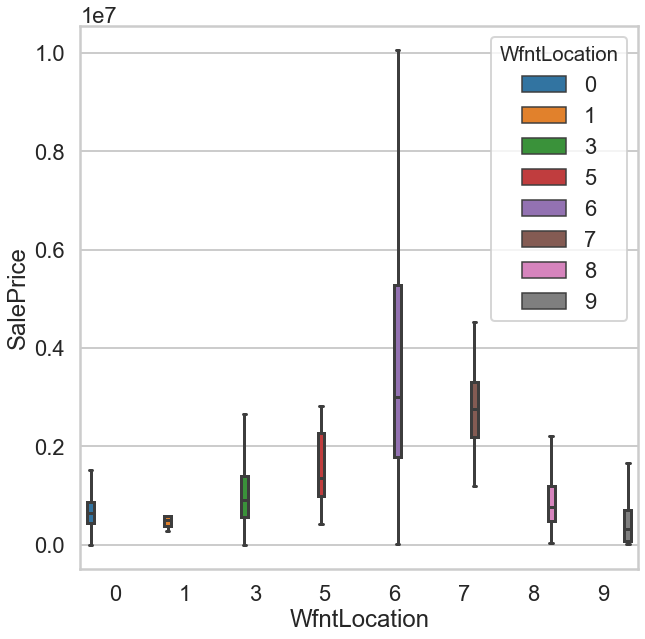

In [223]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.boxplot(data=df_wf, x="WfntLocation", y="SalePrice", orient = 'v', hue = 'WfntLocation', showfliers = False)

In [229]:
df_wf['WfntLocation_cat'] = df_wf['WfntLocation'].astype('str')

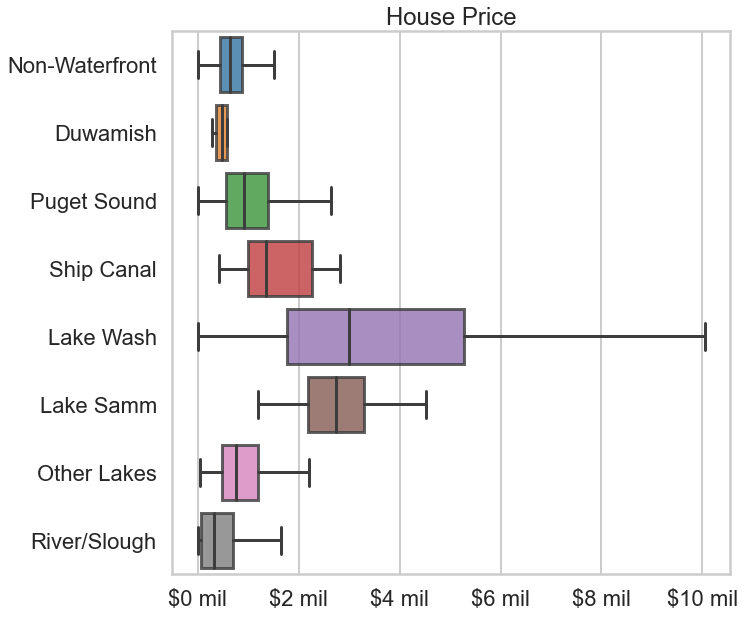

In [476]:
fig, ax = plt.subplots(figsize=(10, 10))
x_ticks = ['0', '$0 mil','$2 mil','$4 mil','$6 mil','$8 mil','$10 mil']
y_ticks = ['Non-Waterfront','Duwamish', 'Puget Sound', 'Ship Canal', 'Lake Wash', 'Lake Samm', 'Other Lakes', 'River/Slough']
ax = sns.boxplot(x=df_wf['SalePrice'], y=df_wf['WfntLocation_cat'], orient ='h', showfliers = False, boxprops=dict(alpha=.8))
ax.set_title("House Price")
ax.set_xlabel('')
ax.set_xticklabels(x_ticks)
ax.set_ylabel('')
ax.set_yticklabels(y_ticks)
figure = ax.get_figure().savefig("wf_avg_breakdown", dpi = 400, bbox_inches = "tight")

In [333]:
df_wf['WfntLocation_cat'].value_counts()

0    24071
9      152
6      128
8      128
3      101
7       37
5        7
1        4
Name: WfntLocation_cat, dtype: int64

In [193]:
df_w = df[df['WfntLocation'] > 0]['SalePrice'].copy()
df_nw = df[df['WfntLocation'] == 0]['SalePrice'].copy()
print(len(df_w), len(df_nw))

557 24071


[(-0.5, 0.5), (0.0, 10000000.0)]

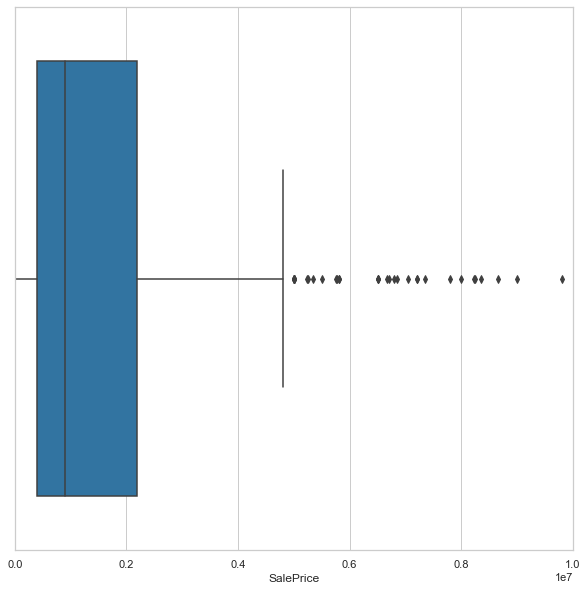

In [194]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.boxplot(df_w)
ax.set(xlim=(0, 10000000), ylim = (-0.5,0.5))

[(-0.5, 0.5), (0.0, 10000000.0)]

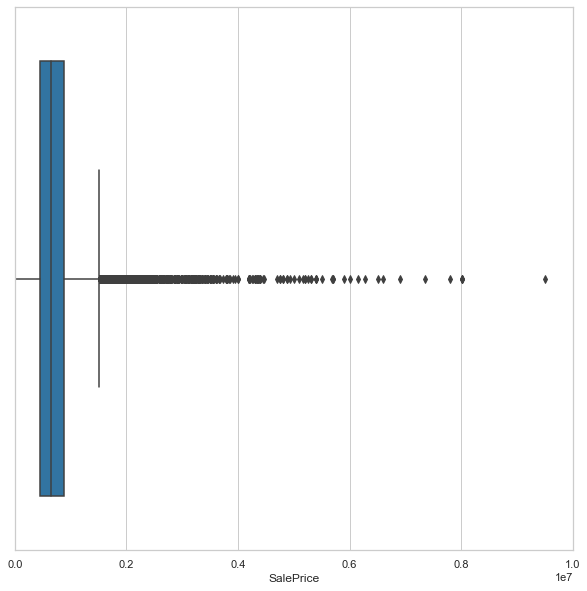

In [195]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.boxplot(df_nw)
ax.set(xlim=(0, 10000000), ylim = (-0.5,0.5))

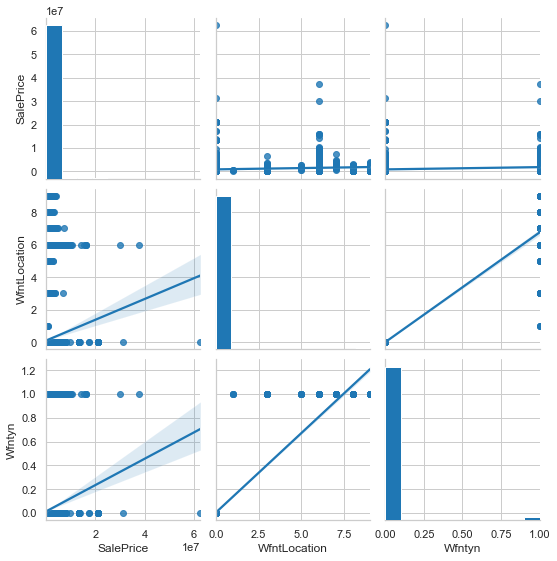

In [196]:
sns.pairplot(df_wf, kind = 'reg')

In [289]:
df_wf['Wfntyn'].value_counts()

0    24071
1      557
Name: Wfntyn, dtype: int64

In [197]:
# # create a smaller df to save space and processing power
fsm_df = df_wf[['SalePrice', 'Wfntyn']].copy()
fsm_df.dropna(inplace=True)
fsm = ols(formula="SalePrice ~ Wfntyn", data=fsm_df)
fsm_results = fsm.fit()
fsm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     267.9
Date:                Thu, 01 Oct 2020   Prob (F-statistic):           6.76e-60
Time:                        12:04:44   Log-Likelihood:            -3.8320e+05
No. Observations:               24628   AIC:                         7.664e+05
Df Residuals:                   24626   BIC:                         7.664e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.234e+05   8922.206     92.291      0.000    8.06e+05    8.41e+05
Wfntyn      9.711e+05   5.93e+04     16.368      0.000    8.55e+05    1.09e+06
==============================================================================
Omnibus:                    46405.009   Durbin-Watson:                   0.732
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        104307882.860
Skew:                          14.409   Prob(JB):                         0.00
Kurtosis:                     320.518   Cond. No.                         6.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [328]:
ttest_result = ttest_ind(df_w, df_nw, equal_var = False)
ttest_result

Ttest_indResult(statistic=7.76019528074887, pvalue=4.031454210528804e-14)

In [199]:
p = ttest_result.pvalue
p

4.031454210528804e-14

250000

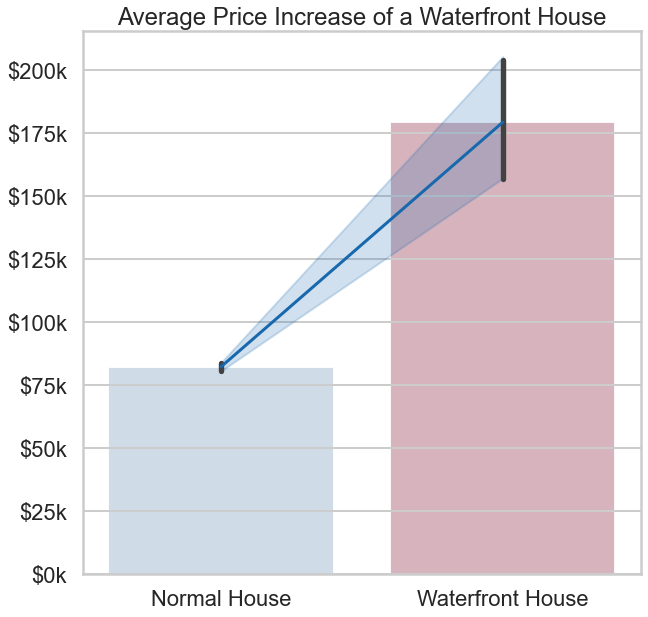

In [456]:
fig, ax = plt.subplots(figsize=(10, 10))
bar_colors = ['#c6d7eb', '#d9a5b3', '#1868ae']
x_ticks = ['Normal House', 'Waterfront House']
y_ticks = ['$0k', '$25k', '$50k', '$75k', '$100k', '$125k', '$150k', '$175k', '$200k']
ax = sns.barplot(data = df_wf, x = "Wfntyn", y = "SalePrice", alpha = 0.9, palette = bar_colors, ci = 93, zorder = 0)
sns.lineplot(data = df_wf, x = 'Wfntyn', y = 'SalePrice', alpha = 1, color = bar_colors[2], zorder = 10)
ax.set_title("Average Price Increase of a Waterfront House")
ax.set_xlabel('')
ax.set_xticklabels(x_ticks)
ax.set_ylabel('')
ax.set_yticklabels(y_ticks)
250000

In [413]:
w_outlier = ( 3 * df_w.std() ) + df_w.mean()
nw_outlier = ( 3 * df_nw.std() ) + df_nw.mean()
df1 = df_wf[(df_wf['Wfntyn'] == 0) & (df_wf['SalePrice'] <= nw_outlier)]
df2 = df_wf[(df_wf['Wfntyn'] == 1) & (df_wf['SalePrice'] <= w_outlier)]
df_wf_cheap = df1.append(df2)
df_wf_cheap.shape

(24487, 4)

In [468]:
df_wf_cheap[df_wf_cheap['Wfntyn'] == 1]['SalePrice'].mean() - df_wf_cheap[df_wf_cheap['Wfntyn'] == 0]['SalePrice'].mean()

812957.1365311973

In [454]:
# # create a smaller df to save space and processing power
fsm_df = df_wf_cheap[['SalePrice', 'Wfntyn']].copy()
fsm_df.dropna(inplace=True)
fsm = ols(formula="SalePrice ~ Wfntyn", data=fsm_df)
fsm_results = fsm.fit()
fsm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     1217.
Date:                Thu, 01 Oct 2020   Prob (F-statistic):          2.96e-260
Time:                        15:34:42   Log-Likelihood:            -3.5797e+05
No. Observations:               24487   AIC:                         7.159e+05
Df Residuals:                   24485   BIC:                         7.160e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.403e+05   3492.582    211.973      0.000    7.33e+05    7.47e+05
Wfntyn       8.13e+05   2.33e+04     34.885      0.000    7.67e+05    8.59e+05
==============================================================================
Omnibus:                    19163.630   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           781527.684
Skew:                           3.428   Prob(JB):                         0.00
Kurtosis:                      29.814   Cond. No.                         6.75
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

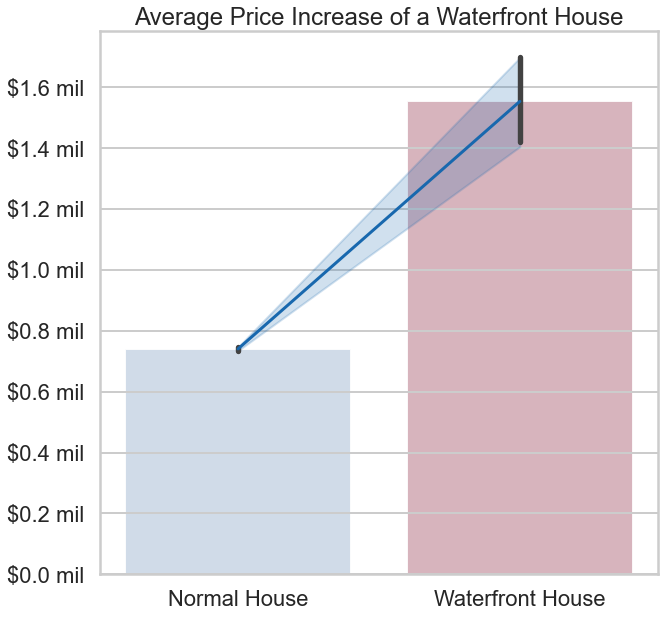

In [482]:
fig, ax = plt.subplots(figsize=(10, 10))
bar_colors = ['#c6d7eb', '#d9a5b3', '#1868ae']
x_ticks = ['Normal House', 'Waterfront House']
y_ticks = ['$0.0 mil', '$0.2 mil', '$0.4 mil', '$0.6 mil', '$0.8 mil', '$1.0 mil', '$1.2 mil', '$1.4 mil', '$1.6 mil']
ax = sns.barplot(data = df_wf_cheap, x = "Wfntyn", y = "SalePrice", alpha = 0.9, palette = bar_colors, ci = 95, zorder = 0)
sns.lineplot(data = df_wf_cheap, x = 'Wfntyn', y = 'SalePrice', alpha = 1, color = bar_colors[2], zorder = 10)
ax.set_title("Average Price Increase of a Waterfront House")
ax.set_xlabel('')
ax.set_xticklabels(x_ticks)
ax.set_ylabel('')
ax.set_yticklabels(y_ticks)
figure = ax.get_figure().savefig("wf_avg_price", dpi = 400, bbox_inches = "tight")

# Waterfront housing are way more expensive

In [427]:
print(df_wf[df_wf['Wfntyn'] == 0]['SalePrice'].mean(), df_wf_cheap[df_wf_cheap['Wfntyn'] == 0]['SalePrice'].mean())

823443.3041003697 740333.2507415299


In [429]:
df_wf_cheap[df_wf_cheap['Wfntyn'] == 0]['SalePrice'].mean()

740333.2507415299

# p value is small so we fail to reject the null hypothesis; we accept the alternative hypothesis

In [81]:
df_cat.head()

NameError: name 'df_cat' is not defined

In [ ]:
df_cat = df.select_dtypes(include = 'object')
df_cat.drop(columns = ['Merged_Key', 'DocumentDate', 'PropType', 'Address', 'DaylightBasement'], inplace = True, errors = 'ignore')
df_cat.head()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# transformed = jobs_encoder.transform(df_cat['WfntAccessRights'].to_numpy().reshape(-1, 1))
#Create a Pandas DataFrame of the hot encoded column
# ohe_df = pd.DataFrame(transformed, columns=jobs_
#                       .get_feature_names())
# #concat with original data
# data = pd.concat([data, ohe_df], axis=1).drop(['Profession'], axis=1)

In [ ]:
enc.fit(df_cat)

In [ ]:
enc.categories_

In [ ]:
df.NbrLivingUnits.value_counts()

In [ ]:
df.loc[df['NbrLivingUnits'].isin([1,2])]

In [ ]:
len(df_nw)

In [ ]:
len(df_w)